# Lab 5 - Using link functions to create generalized linear models

We consider the dataset from the lecture considering Airline accidents and deaths.
Now the dataset is provided in ```Airline_data.csv``` file and you can create your own model. This time you dont get a jupyter notebook to fill so create your own. 

During the lecture we have tried Poisson models with varying degrees of success. Our considered models were (assuming $y_i$ is the number of accidents in given year):
- $y_i\sim\mathrm{Poisson}(\lambda)$ that is one fixed $\lambda$ for all years i.e. number of accidents is random independent on year where it happens
-  $y_i\sim\mathrm{Poisson}(\theta n_i)$ where $n_i$ is the ammount of miles flown that year. 

We will now try to improve upon those models using new structures and parameters. Lets add an additional mean ammount of accidents i.e model with intercept $\lambda_i=\alpha+\theta n_i$. This might be problematic, as coefficient $\lambda$ has to be positive, without appropriate carefulness it could create errors in sampling. Typical approach is to use a *link function*, i.e. function that would transform domain of parameter to one that is applicable. For Poisson distributions it is popular to use logarithm:

$$\log \lambda_i=\alpha+\theta n_i$$

which translates to the following sampling statement

$$ y_i\sim\mathrm{Poisson}(\underbrace{\exp(\alpha+\theta n_i)}_{\lambda_i})$$

Create such model and perform prior predictive analysis to choose priors. 

**Important** chose priors wisely, as exponential function can become quite large and return errors in sampling when it becomes too big. Perhaps before sampling of Poisson try to find what kind of values for $\lambda_i$ come from priors. 

After testing priors fit the model to data and evaluate its efficiency by by posterior predictive distribution and comparing histograms of accidents for entire period and for each year.

Try to improve the model by replacing single intercept $\alpha$ with individual intercepts of $\alpha_i$ for each year. It can be easily done, by declaring $\alpha$ as an array of appropriate dimension. Then only one prior is needed as it will be used for all the elements of the array.

Again perform the prior predictive distribution analysis to select prior parameters, fit the model and analyze its output. 


In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data importing

In [4]:
# Get main data DataFrame
data_df = pd.read_csv('Airline_data.csv')
display(data_df)
display(data_df.describe())

,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
0,1976,24,734,3863.0
1,1977,25,516,4300.0
2,1978,31,754,5027.0
3,1979,31,877,5481.0
4,1980,22,814,5814.0
5,1981,21,362,6033.0
6,1982,26,764,5877.0
7,1983,20,809,6223.0
8,1984,16,223,7433.0
9,1985,22,1066,7107.0


,Year,Fatal accidents,Passenger deaths,Miles flown [100 mln miles]
count,10.00000,10.000000,10.000000,10.000000
mean,1980.50000,23.800000,691.900000,5715.800000
std,3.02765,4.709329,252.389228,1117.767795
min,1976.00000,16.000000,223.000000,3863.000000
25%,1978.25000,21.250000,570.500000,5140.500000
50%,1980.50000,23.000000,759.000000,5845.500000
75%,1982.75000,25.750000,812.750000,6175.500000
max,1985.00000,31.000000,1066.000000,7433.000000


## 1. Prior predictive check

In [6]:
model_ppc = CmdStanModel(stan_file='stan_codes/prior_check.stan')

# Prepare data
alpha = np.log(data_df['Fatal accidents'].mean())
## Miles scaled to be in <0, 1> range
miles = data_df['Miles flown [100 mln miles]'].mean() / 10000

# Sampling
ppc = model_ppc.sample(data={'alpha' : alpha, 'miles' : miles},
                       iter_sampling=1000, 
                       iter_warmup=0, 
                       chains=1)

# Get DataFrame
ppc_df = ppc.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


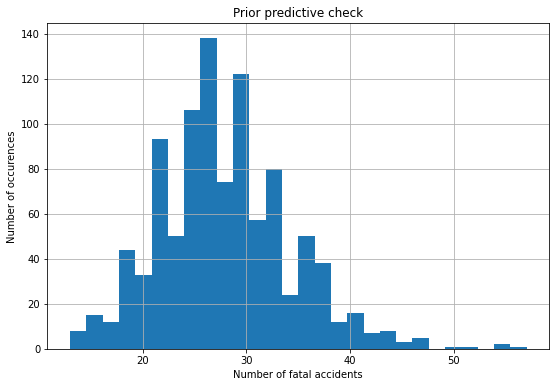

In [8]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.hist(ppc_df['y_sim'], bins='auto')
ax.set(title='Prior predictive check',
       xlabel='Number of fatal accidents',
       ylabel='Number of occurences')
ax.grid()
plt.show()

## 2. Post predictive distribution
Already with **individual intercepts of alpha**

In [10]:
model_pst = CmdStanModel(stan_file='stan_codes/posterior.stan')

# Prepare data
N = len(data_df)
y = data_df['Fatal accidents'].values
## Miles scaled to be in <0, 1> range
miles = data_df['Miles flown [100 mln miles]'] / 10000

# Sampling
ppd = model_pst.sample(data={'N': N, 'y': y, 'miles': miles})

# Get DataFrame
ppd_df = ppd.draws_pd()


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


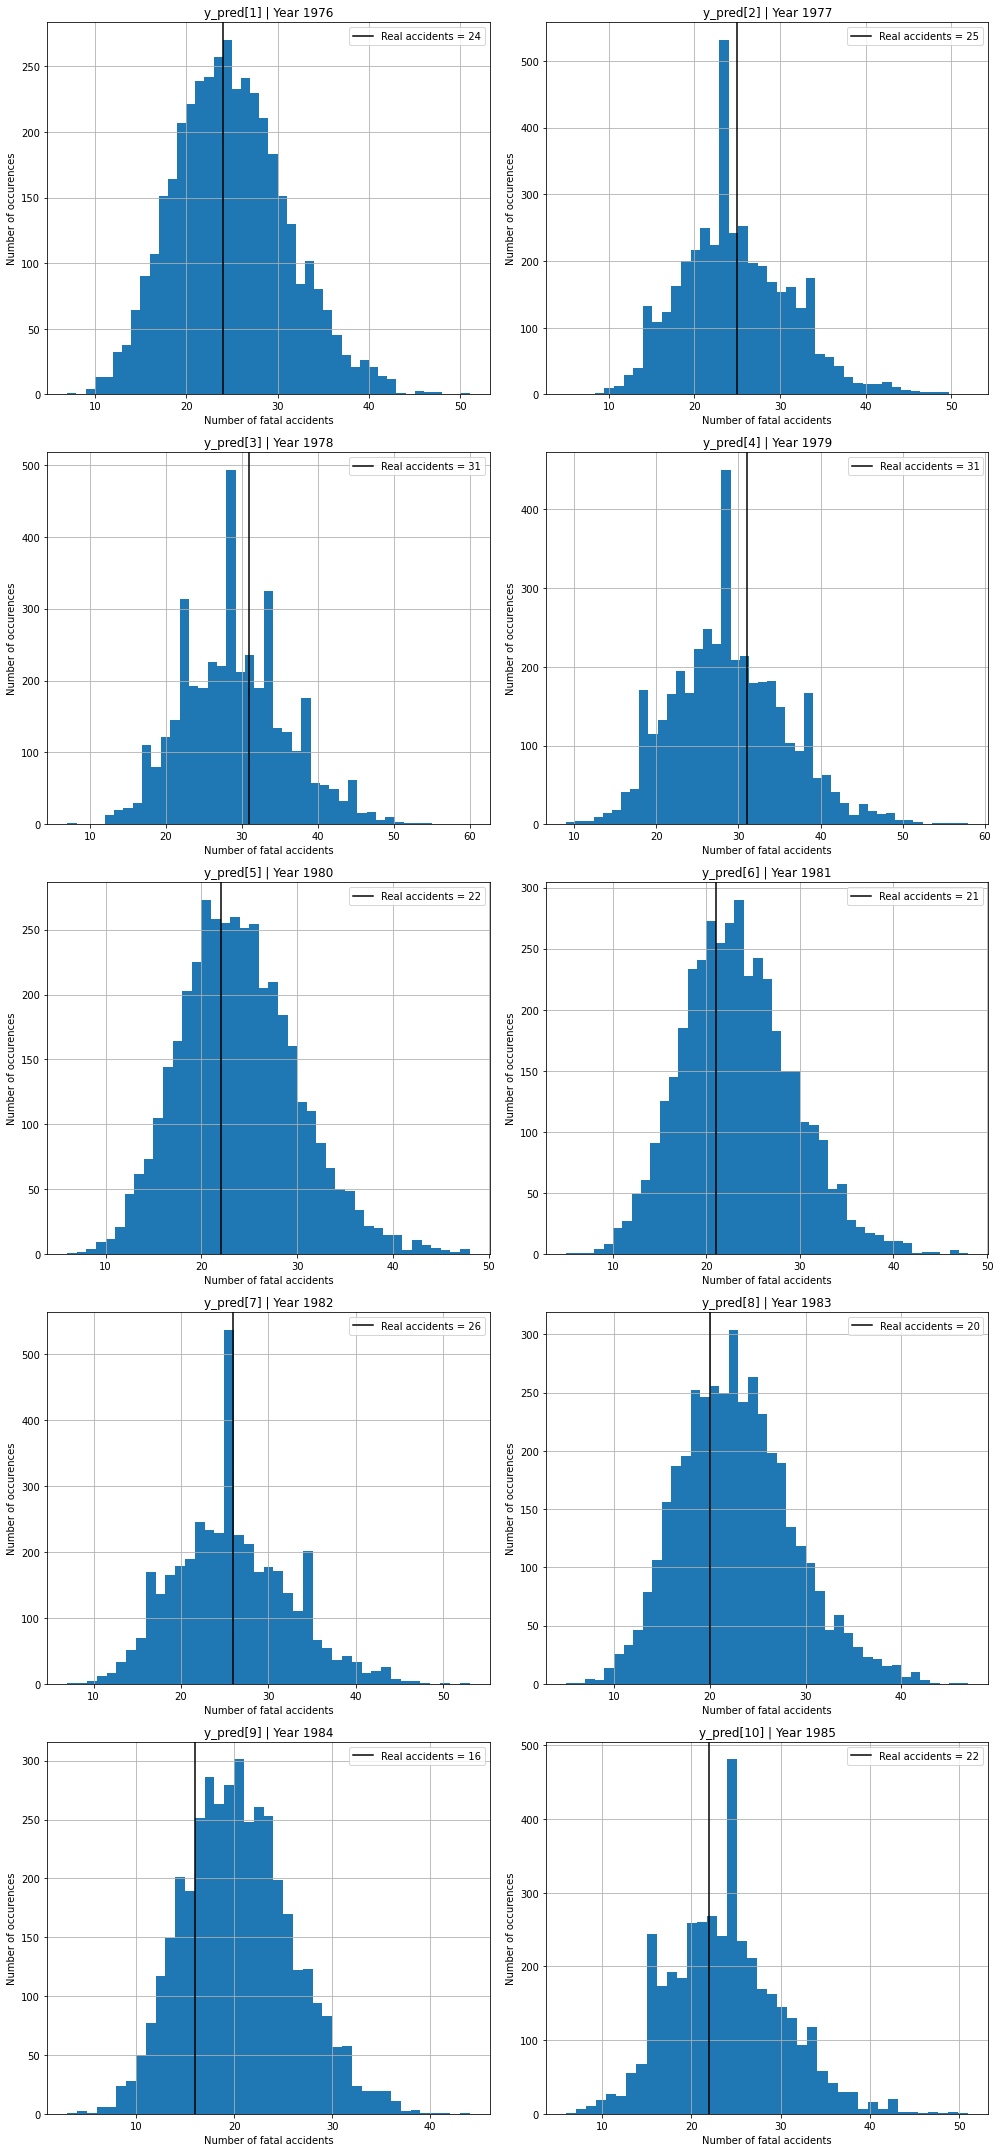

In [28]:
# Plot
fig, axs = plt.subplots(5, 2, figsize=(14, 30))
for i, ax in enumerate(axs.ravel()):
    # Plot PPD data histogram
    ax.hist(ppd_df[f'y_pred[{i+1}]'].values, bins='auto')
    
    # Plot vline for real data
    fatal_accidents = data_df['Fatal accidents'][i]
    ax.axvline(fatal_accidents, color='black', label=f'Real accidents = {fatal_accidents}')
    
    # Set additional display stuff
    year = data_df['Year'][i]
    ax.set(title=f'y_pred[{i+1}] | Year {year}',
           xlabel='Number of fatal accidents',
           ylabel='Number of occurences')
    ax.legend()
    ax.grid()
fig.tight_layout()
plt.show()